### Ambre JACQUOT et Yan WU

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [43]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc,make_scorer,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# I. Apprentissage supervisé : Feature engineering et classification

1. Chargement des données et préparation

In [49]:
# Importer le jeu de données
df_client=pd.read_csv('client_scoring.csv',sep=';')

# Convertir le data frame en numpy array
client=df_client.to_numpy()

# Séparer les variables caractéristiques de la variable à prédire en deux tableaux différents
y=client[:,13] # statut
x=client[:,0:13] # variables caractéristiques

# Analyse des propriétés des données
print('taille de l\'échantillon : nombre de lignes :',client.shape[0],' et nombre de colonnes :',client.shape[1])
print('pourcentage de 0 :',np.sum(y==0)/client.shape[0]*100,'% et pourcentage de 1:',np.sum(y==1)/client.shape[0]*100,'%')

# Séparation des données en apprentissage/test
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.5, random_state=1)


taille de l'échantillon : nombre de lignes : 4375  et nombre de colonnes : 14
pourcentage de 0 : 27.794285714285717 % et pourcentage de 1: 72.20571428571428 %


2. Apprentissage et évaluation de modèles

In [4]:
# Arbre CART
cart = DecisionTreeClassifier(random_state=1)
cart.fit(X_train, y_train)

# k-plus-proches-voisins avec k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# MultilayerPerceptron à deux couches
mlp = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
mlp.fit(X_train, y_train)

,hidden_layer_sizes,"(40, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,1


In [5]:
# Fonction d'évaluation 
def evaluate_classifier(modele,X_test,y_test,nom): 
    y_pred=modele.predict(X_test)
    y_proba=modele.predict_proba(X_test)[:, 1]

    # Affichage des métriques
    print(f"\n--- {nom} ---")
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Accuracy :", accuracy_score(y_test, y_pred))
    # Dans le cas de la solvabilité client, on prends la précision. En effet, il vaut mieux avoir une précision élevée plutôt qu'un score élevé sinon il y a une plus grande chance de subir des pertes
    print("Précision :", precision_score(y_test, y_pred))
    #print("Rappel :", recall_score(y_test, y_pred))
    score_final=(accuracy_score(y_test, y_pred)+precision_score(y_test,y_pred))/2
    print('Score final :',score_final )

    # Courbe ROC avec l'AUC
    a, b, _=roc_curve(y_test, y_proba)
    roc_auc=auc(a, b)
    
    return (a,b,roc_auc,score_final)

In [6]:
# Fonction d'apprentissage et de test
def run_classifiers_train_test(clf,X_train, X_test, y_train, y_test):
    scores = {}
    plt.figure(figsize=(8, 6))

    for nom, model in clf.items():
        # Entraînement de chaque algorithme de clf
        model.fit(X_train, y_train)
        # Affichage des résultats d'évaluation de la fonction evaluate_classifier
        a,b,roc_auc,score = evaluate_classifier(model, X_test, y_test,nom)
        scores[nom] = score
        # pour afficher toutes les courbes ROC sur le même graphique
        plt.plot(a, b, label=f"{nom} (AUC = {roc_auc:.2f})")


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Faux positifs")
    plt.ylabel("Vrais positifs")
    plt.title("Courbes ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Choix final du meilleur modèle selon le score final
    meilleur_modele= max(scores, key=scores.get)
    print(f"\n Meilleur modèle : {meilleur_modele} avec un score de {scores[meilleur_modele]}")
    return clf[meilleur_modele]



--- CART ---
Matrice de confusion :
 [[ 325  279]
 [ 318 1266]]
Accuracy : 0.7271480804387569
Précision : 0.8194174757281554
Score final : 0.7732827780834561

--- KNN ---
Matrice de confusion :
 [[ 189  415]
 [ 187 1397]]
Accuracy : 0.7248628884826326
Précision : 0.7709713024282561
Score final : 0.7479170954554444

--- MLP ---
Matrice de confusion :
 [[ 400  204]
 [ 517 1067]]
Accuracy : 0.6704753199268738
Précision : 0.8394964594807238
Score final : 0.7549858897037989


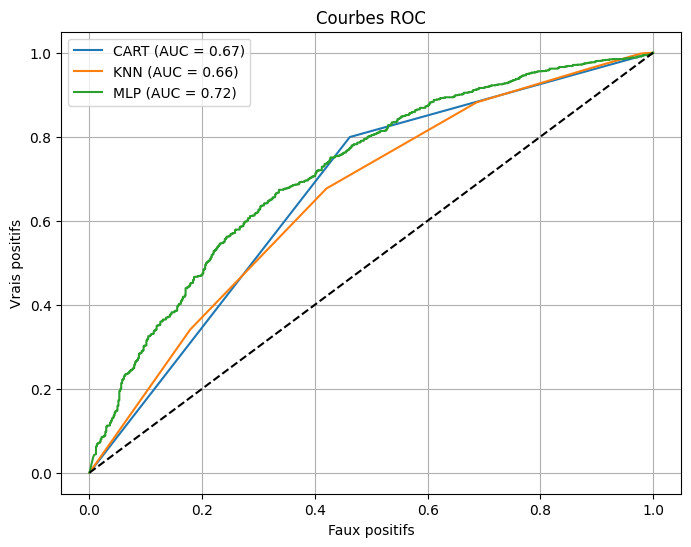


 Meilleur modèle : CART avec un score de 0.7732827780834561


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [7]:
# Dictionnaire contenant les algorithmes supervisés
clf = {"CART": cart,"KNN": knn,"MLP": mlp}

# Meilleur classifieur
run_classifiers_train_test(clf,X_train, X_test, y_train, y_test)

3. Normalisation des variables continues

=== Résultats après normalisation ===

--- CART ---
Matrice de confusion :
 [[ 322  282]
 [ 315 1269]]
Accuracy : 0.7271480804387569
Précision : 0.8181818181818182
Score final : 0.7726649493102875

--- KNN ---
Matrice de confusion :
 [[ 286  318]
 [ 223 1361]]
Accuracy : 0.7527422303473492
Précision : 0.8106015485407981
Score final : 0.7816718894440737

--- MLP ---
Matrice de confusion :
 [[ 342  262]
 [ 227 1357]]
Accuracy : 0.776508226691042
Précision : 0.8381717109326745
Score final : 0.8073399688118583


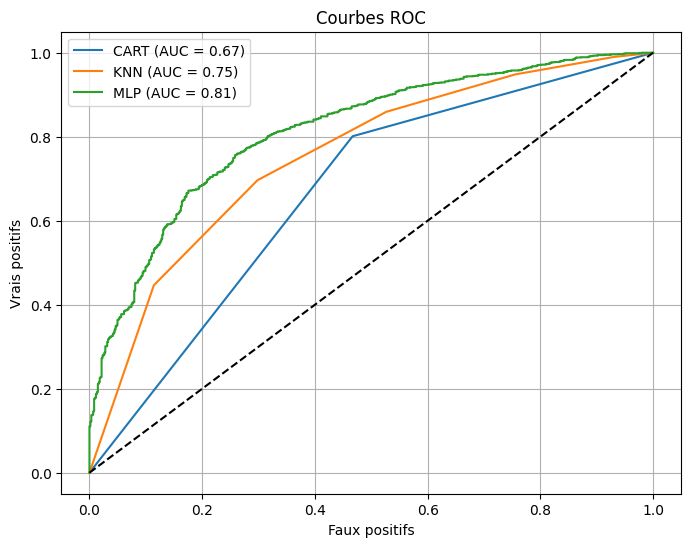


 Meilleur modèle : MLP avec un score de 0.8073399688118583


,hidden_layer_sizes,"(40, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,1


In [8]:
# Normalisation des variables continues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Arbre CART
cart = DecisionTreeClassifier(random_state=1)
cart.fit(X_train_scaled, y_train)

# k-plus-proches-voisins avec k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# MultilayerPerceptron à deux couches
mlp.fit(X_train_scaled, y_train)

# Ré-entraînement des modèles sur les données normalisées
modeles_scaled ={"CART": cart,"KNN": knn,"MLP": mlp}
# Évaluation des modèles normalisés 
print("=== Résultats après normalisation ===")
run_classifiers_train_test(modeles_scaled,X_train_scaled, X_test_scaled, y_train, y_test)

Dans cette expérience, nous avons comparé les performances des trois modèles (CART, kNN et MLP) avant et après normalisation des variables continues.
CART n’est pratiquement pas affecté, car les arbres de décision ne dépendent pas des distances entre les points mais uniquement de seuils sur les variables. kNN s’améliore nettement après normalisation : comme ce modèle repose sur la distance euclidienne, mettre toutes les variables sur la même échelle permet un calcul plus équilibré des voisins. MLP présente également de meilleurs résultats, la normalisation facilitant la convergence de la descente de gradient et stabilisant l’apprentissage.

4. Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales

=== Résultats après ajout des composantes PCA ===

--- CART ---
Matrice de confusion :
 [[ 335  269]
 [ 331 1253]]
Accuracy : 0.7257769652650823
Précision : 0.8232588699080158
Score final : 0.7745179175865491

--- KNN ---
Matrice de confusion :
 [[ 283  321]
 [ 212 1372]]
Accuracy : 0.756398537477148
Précision : 0.8103957471943296
Score final : 0.7833971423357389

--- MLP ---
Matrice de confusion :
 [[ 339  265]
 [ 232 1352]]
Accuracy : 0.7728519195612431
Précision : 0.8361162646876933
Score final : 0.8044840921244683


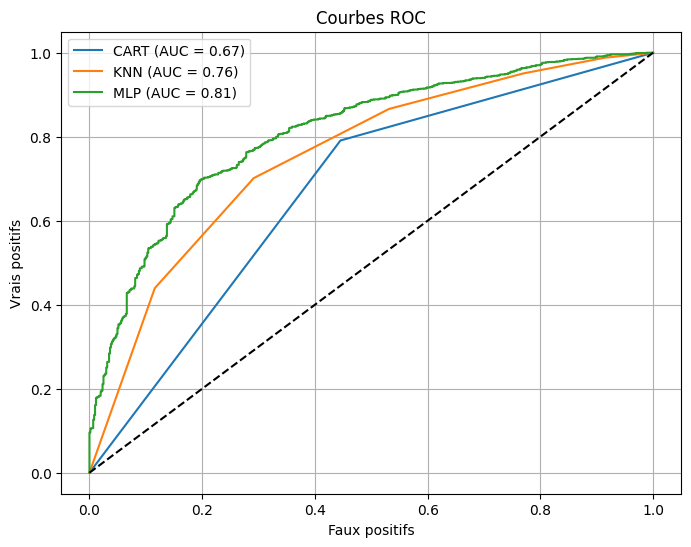


 Meilleur modèle : MLP avec un score de 0.8044840921244683


,hidden_layer_sizes,"(40, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,1


In [9]:
# ACP sur les données normalisées
pca = PCA(n_components=3)

# Fit uniquement sur le train 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

#Concaténation : données normalisées + 3 composantes PCA
X_train_final = np.concatenate([X_train_scaled, X_train_pca], axis=1)
X_test_final  = np.concatenate([X_test_scaled, X_test_pca],  axis=1)

# Arbre CART
cart = DecisionTreeClassifier(random_state=1)
cart.fit(X_train_final, y_train)

# k-plus-proches-voisins avec k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_final, y_train)

# MultilayerPerceptron à deux couches
mlp = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
mlp.fit(X_train_final, y_train)

#  Ré-entraînement des modèles sur les nouvelles données
modeles_scaled ={"CART": cart,"KNN": knn,"MLP": mlp}
# Évaluation des modèles normalisés
print("=== Résultats après ajout des composantes PCA ===")
run_classifiers_train_test(modeles_scaled,X_train_final, X_test_final, y_train, y_test)


Après avoir ajouté les 3 premières composantes principales de l’ACP aux données normalisées, on observe que : CART change très peu, car un arbre n’utilise pas les combinaisons linéaires d’attributs ; il se base uniquement sur des seuils dans l’espace original. KNN peut légèrement s’améliorer, car les composantes PCA capturent l’essentiel de la variance et fournissent une représentation plus compacte et plus discriminante. Alors que le MLP subit une légère baisse.

Selon le score final, le meilleur modèle est toujours le MLP, on va le garder pour la suite de ce TP car il a le meilleur score final. \
Pour la préparation des données, il vaut mieux normaliser pour garantir de bonnes performances mais on ne fera pas d'ACP pour la suite du TP.

5. Sélection de variables

In [10]:
# Fonction sur l'importance des variables
def importance_relative(Xtrain,Ytrain,nom_cols):
    clf = RandomForestClassifier(n_estimators=1000,random_state=1)
    clf.fit(Xtrain, Ytrain)
    importances=clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    sorted_idx = np.argsort(importances)[::-1]
    features =nom_cols
    print(features[sorted_idx])
    padding = np.arange(Xtrain.size/len(Xtrain)) + 0.5
    plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
    plt.yticks(padding, features[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()
    return sorted_idx

Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
      dtype='object')


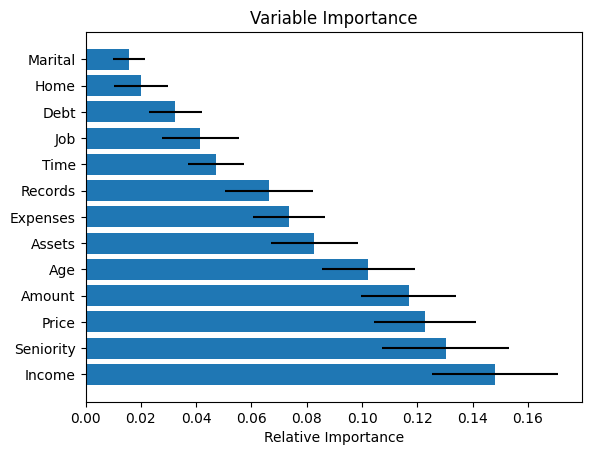

In [11]:
nom_cols = df_client.columns
sorted_idx=importance_relative(X_train_scaled, y_train, nom_cols)

In [12]:
# Fonction sur la sélection du nombre optimal de variables
def selection(modele, Xtrain,Xtest,Ytrain,Ytest,sorted_idx):
    scores=np.zeros(Xtrain.shape[1])
    for f in np.arange(0, Xtrain.shape[1]):
        X1_f = Xtrain[:,sorted_idx[:f+1]]
        X2_f = Xtest [:,sorted_idx[:f+1]]
        modele.fit(X1_f,Ytrain)
        Ypred=modele.predict(X2_f)
        scores[f]=np.round(accuracy_score(Ytest,Ypred),3)
    plt.plot(scores)
    plt.xlabel("Nombre de Variables")
    plt.ylabel("Accuracy")
    plt.title("Evolution de l'accuracy en fonction des variables")
    plt.show()
    k_opt = np.argmax(scores) + 1 
    return k_opt

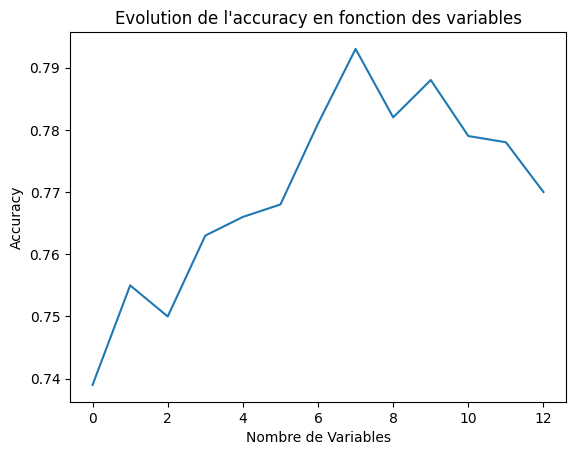

In [13]:
modele =MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
k_opt=selection(modele, X_train_scaled, X_test_scaled, y_train, y_test,sorted_idx)

6. Paramétrage des classifieurs

In [14]:
# Fonction qui optimise au mieux le critère: (accuracy + précision) / 2
def acc_prec_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + precision_score(y_true, y_pred, average='binary', zero_division=0)) / 2

# Transforme la fonction en scorer compatible avec scikit-learn
acc_prec_scorer = make_scorer(acc_prec_score)

def tuning_mlp(Xtrain, Xtest, Ytrain, Ytest, sorted_idx, k_opt):
    # on se restreint aux k_opt meilleures variables
    Xtrain_sel = Xtrain[:, sorted_idx[:k_opt]]
    Xtest_sel  = Xtest[:,  sorted_idx[:k_opt]]
    mlp = MLPClassifier(random_state=1,max_iter=500)
    # Grille simple d'hyperparamètres
    param_grid = {
        "hidden_layer_sizes": [(40, 20), (50, 25)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "alpha": [0.0001, 0.001],
        "learning_rate_init": [0.001, 0.01]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # GridSearchCV pour optimiser (accuracy + précision) / 2
    grid = GridSearchCV(mlp, param_grid, scoring=acc_prec_scorer, cv=cv, n_jobs=-1, refit=True)
    grid.fit(Xtrain_sel, Ytrain)
    # Meilleur modèle et évaluation sur test
    best_mlp = grid.best_estimator_
    Ypred = best_mlp.predict(Xtest_sel)
    acc = accuracy_score(Ytest, Ypred)
    prec = precision_score(Ytest, Ypred, average='binary', zero_division=0)
    final_score = (acc + prec) / 2
    try:
        auc = roc_auc_score(Ytest, best_mlp.predict_proba(Xtest_sel)[:, 1])
    except:
        auc = None

    print("Meilleurs paramètres:", grid.best_params_)
    print("Score CV moyen (acc+prec)/2:", grid.best_score_)
    print("Score test final:", final_score)
    print("Accuracy:", acc, "| Précision:", prec, "| AUC:", auc)
    print("Matrice de confusion:\n", confusion_matrix(Ytest, Ypred))

    return best_mlp

In [15]:
best_mlp = tuning_mlp(X_train_scaled, X_test_scaled, y_train, y_test, sorted_idx, k_opt)

Meilleurs paramètres: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 20), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Score CV moyen (acc+prec)/2: 0.7940504270579876
Score test final: 0.8100152897297868
Accuracy: 0.7975319926873857 | Précision: 0.8224985867721877 | AUC: 0.8293463400561911
Matrice de confusion:
 [[ 290  314]
 [ 129 1455]]


7. Création d'un pipeline

In [16]:
def creation_pipeline(Xtrain, Xtest, Ytrain, Ytest, sorted_idx, k_opt, best_model, filename="pipeline_final.pkl"):    
    Xtrain_sel = Xtrain[:, sorted_idx[:k_opt]]
    Xtest_sel  = Xtest[:,  sorted_idx[:k_opt]]
    pipeline = Pipeline([("scaler", StandardScaler()),("clf", best_model)])
    pipeline.fit(Xtrain_sel, Ytrain)
    score = pipeline.score(Xtest_sel, Ytest)
    print("Score pipeline:", score)
    with open(filename, "wb") as f:
        pickle.dump(pipeline, f)    
    return pipeline

In [17]:
creation_pipeline(X_train_scaled, X_test_scaled,y_train, y_test,sorted_idx, k_opt,best_mlp, filename="pipeline_mlp.pkl")

Score pipeline: 0.7975319926873857


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(40, ...)"
,activation,'tanh'
,solver,'sgd'
,alpha,0.0001


8. Orchestration


--- CART ---
Matrice de confusion :
 [[ 322  282]
 [ 315 1269]]
Accuracy : 0.7271480804387569
Précision : 0.8181818181818182
Score final : 0.7726649493102875

--- KNN ---
Matrice de confusion :
 [[ 286  318]
 [ 223 1361]]
Accuracy : 0.7527422303473492
Précision : 0.8106015485407981
Score final : 0.7816718894440737

--- MLP ---
Matrice de confusion :
 [[ 342  262]
 [ 227 1357]]
Accuracy : 0.776508226691042
Précision : 0.8381717109326745
Score final : 0.8073399688118583


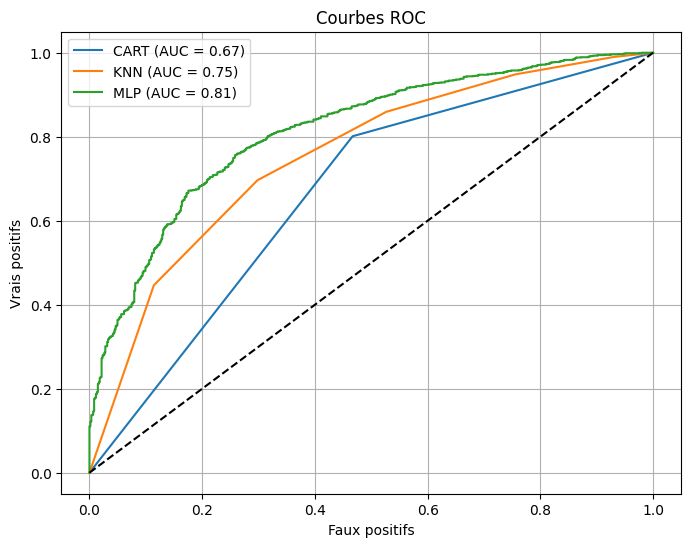


 Meilleur modèle : MLP avec un score de 0.8073399688118583
Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
      dtype='object')


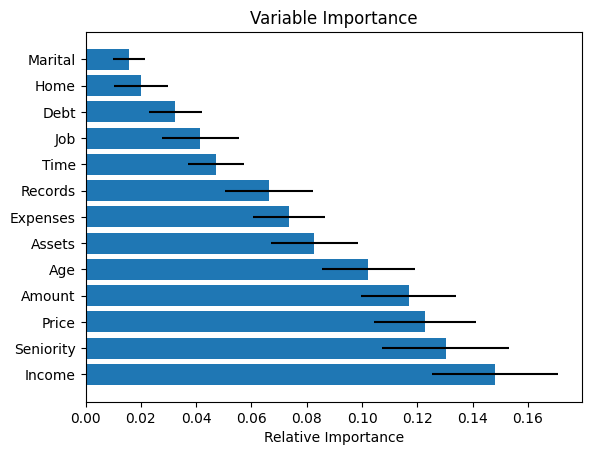

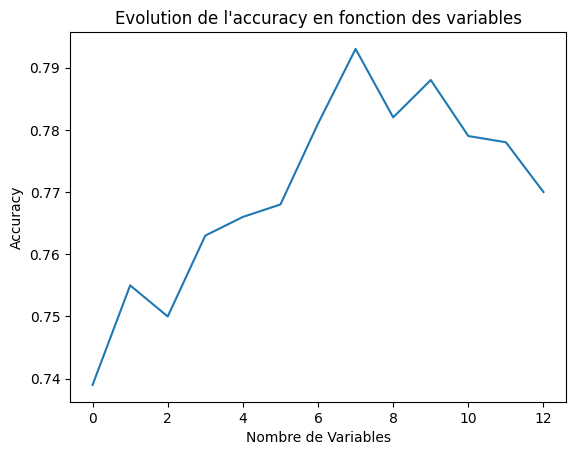

Meilleurs paramètres: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 20), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Score CV moyen (acc+prec)/2: 0.7940504270579876
Score test final: 0.8100152897297868
Accuracy: 0.7975319926873857 | Précision: 0.8224985867721877 | AUC: 0.8293463400561911
Matrice de confusion:
 [[ 290  314]
 [ 129 1455]]
Score pipeline: 0.7975319926873857

Pipeline final sauvegardé dans pipeline_orchestration.pkl


In [18]:
from utils import pipeline_generation_train_test_split
nom_cols = df_client.columns[0:13]
pipeline = pipeline_generation_train_test_split(x, y, nom_cols, filename="pipeline_orchestration.pkl")

9. Comparaison de plusieurs algorithmes d'apprentissage


--- CART ---
Accuracy: 0.749 +/- 0.027
AUC: 0.754 +/- 0.041
(Accuracy+Précision)/2: 0.759 +/- 0.029
Temps d'exécution: 0.09 secondes

--- KNN ---
Accuracy: 0.710 +/- 0.039
AUC: 0.645 +/- 0.047
(Accuracy+Précision)/2: 0.734 +/- 0.038
Temps d'exécution: 0.11 secondes

--- MLP ---
Accuracy: 0.713 +/- 0.059
AUC: 0.693 +/- 0.046
(Accuracy+Précision)/2: 0.739 +/- 0.041
Temps d'exécution: 1.62 secondes

--- Bagging ---
Accuracy: 0.759 +/- 0.020
AUC: 0.799 +/- 0.028
(Accuracy+Précision)/2: 0.783 +/- 0.027
Temps d'exécution: 10.10 secondes

--- AdaBoost ---
Accuracy: 0.786 +/- 0.024
AUC: 0.828 +/- 0.028
(Accuracy+Précision)/2: 0.802 +/- 0.028
Temps d'exécution: 4.18 secondes

--- RandomForest ---
Accuracy: 0.768 +/- 0.016
AUC: 0.818 +/- 0.023
(Accuracy+Précision)/2: 0.787 +/- 0.023
Temps d'exécution: 4.88 secondes

>>> Meilleur modèle selon CV: AdaBoost
Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
   

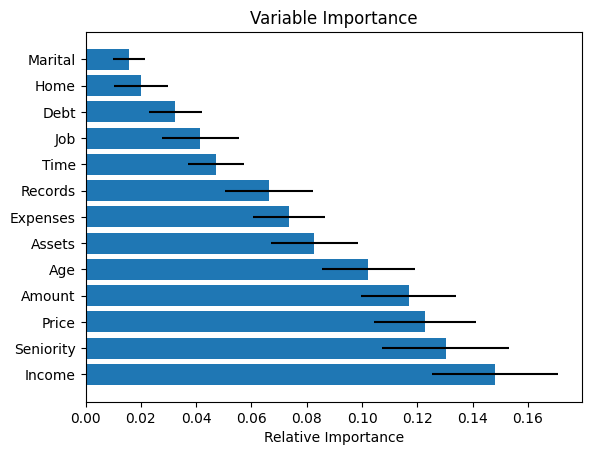

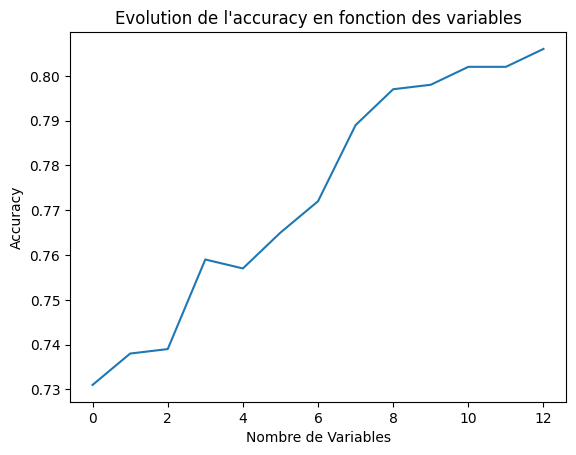

Meilleurs paramètres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.001, 'solver': 'adam'}
Score CV moyen (acc+prec)/2: 0.7477867555238183
Score test final: 0.7762453614895699
Accuracy: 0.6927297668038409 | Précision: 0.8597609561752988 | AUC: 0.7444952795933188
Matrice de confusion:
 [[ 436  176]
 [ 496 1079]]
Score pipeline: 0.9693644261545497

Pipeline CV final sauvegardé dans pipeline_cv.pkl


In [19]:
from utils import pipeline_generation_cv
pipeline = pipeline_generation_cv(X_train, y_train, nom_cols, filename="pipeline_cv.pkl")


--- CART ---
Accuracy: 0.749 +/- 0.027
AUC: 0.754 +/- 0.041
(Accuracy+Précision)/2: 0.759 +/- 0.029
Temps d'exécution: 0.12 secondes

--- KNN ---
Accuracy: 0.746 +/- 0.028
AUC: 0.747 +/- 0.024
(Accuracy+Précision)/2: 0.770 +/- 0.031
Temps d'exécution: 0.16 secondes

--- MLP ---
Accuracy: 0.781 +/- 0.023
AUC: 0.821 +/- 0.021
(Accuracy+Précision)/2: 0.806 +/- 0.024
Temps d'exécution: 10.23 secondes

--- Bagging ---
Accuracy: 0.760 +/- 0.020
AUC: 0.800 +/- 0.028
(Accuracy+Précision)/2: 0.784 +/- 0.026
Temps d'exécution: 8.39 secondes

--- AdaBoost ---
Accuracy: 0.786 +/- 0.024
AUC: 0.828 +/- 0.028
(Accuracy+Précision)/2: 0.802 +/- 0.028
Temps d'exécution: 3.48 secondes

--- RandomForest ---
Accuracy: 0.770 +/- 0.016
AUC: 0.817 +/- 0.023
(Accuracy+Précision)/2: 0.788 +/- 0.022
Temps d'exécution: 4.67 secondes

>>> Meilleur modèle selon CV: MLP
Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
      dt

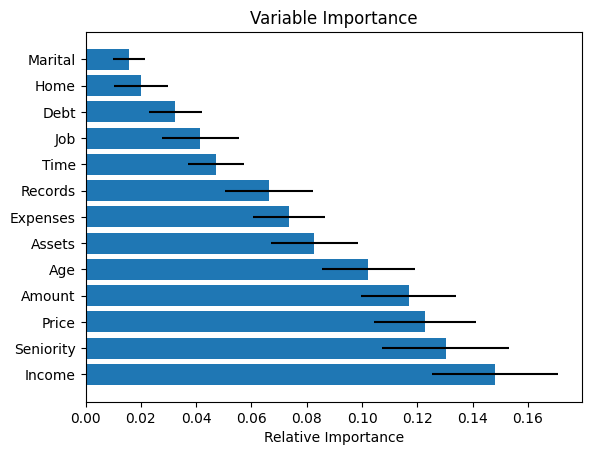

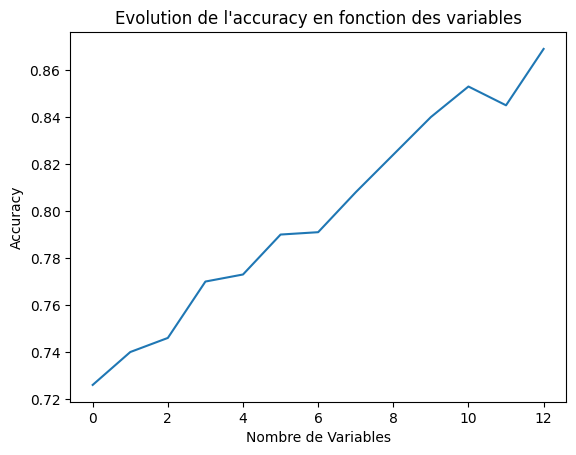

Meilleurs paramètres: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 20), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Score CV moyen (acc+prec)/2: 0.8042652834303279
Score test final: 0.8113623094235858
Accuracy: 0.7983539094650206 | Précision: 0.8243707093821511 | AUC: 0.8407438530967943
Matrice de confusion:
 [[ 305  307]
 [ 134 1441]]
Score pipeline: 0.7983539094650206

Pipeline CV final sauvegardé dans pipeline_cv2.pkl


In [20]:
pipeline_normalise = pipeline_generation_cv(X_train_scaled, y_train, nom_cols, filename="pipeline_cv2.pkl")


--- CART ---
Accuracy: 0.704 +/- 0.031
AUC: 0.632 +/- 0.035
(Accuracy+Précision)/2: 0.719 +/- 0.029
Temps d'exécution: 0.15 secondes

--- KNN ---
Accuracy: 0.704 +/- 0.021
AUC: 0.620 +/- 0.036
(Accuracy+Précision)/2: 0.731 +/- 0.024
Temps d'exécution: 0.12 secondes

--- MLP ---
Accuracy: 0.708 +/- 0.035
AUC: 0.675 +/- 0.027
(Accuracy+Précision)/2: 0.721 +/- 0.037
Temps d'exécution: 11.29 secondes

--- Bagging ---
Accuracy: 0.701 +/- 0.034
AUC: 0.645 +/- 0.029
(Accuracy+Précision)/2: 0.726 +/- 0.033
Temps d'exécution: 13.16 secondes

--- AdaBoost ---
Accuracy: 0.723 +/- 0.031
AUC: 0.663 +/- 0.033
(Accuracy+Précision)/2: 0.731 +/- 0.032
Temps d'exécution: 6.88 secondes

--- RandomForest ---
Accuracy: 0.705 +/- 0.030
AUC: 0.655 +/- 0.030
(Accuracy+Précision)/2: 0.728 +/- 0.029
Temps d'exécution: 9.77 secondes

>>> Meilleur modèle selon CV: AdaBoost
Index(['Home', 'Seniority', 'Time'], dtype='object')


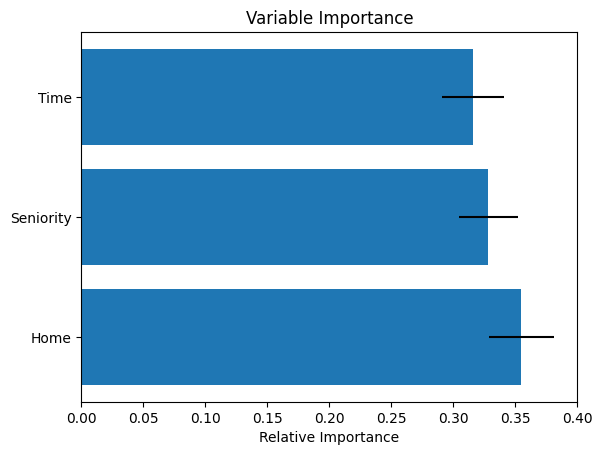

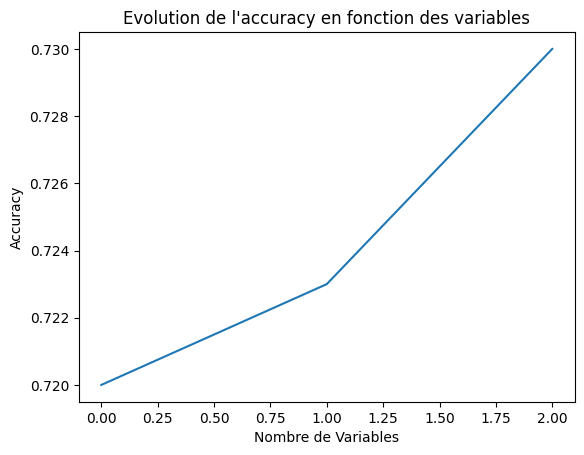

Meilleurs paramètres: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (40, 20), 'learning_rate_init': 0.001, 'solver': 'adam'}
Score CV moyen (acc+prec)/2: 0.7351515798243738
Score test final: 0.7636644121630685
Accuracy: 0.7544581618655692 | Précision: 0.7728706624605678 | AUC: 0.7494937234152921
Matrice de confusion:
 [[ 180  432]
 [ 105 1470]]
Score pipeline: 0.7626886145404664

Pipeline CV final sauvegardé dans pipeline_cv3.pkl


In [21]:
pipeline_normalise = pipeline_generation_cv(X_train_pca, y_train, nom_cols, filename="pipeline_cv3.pkl")

# II. Apprentissage supervisé : Données hétérogènes

1. - Chargement des données et préparation

Taille de l'échantillon :  (666, 6)


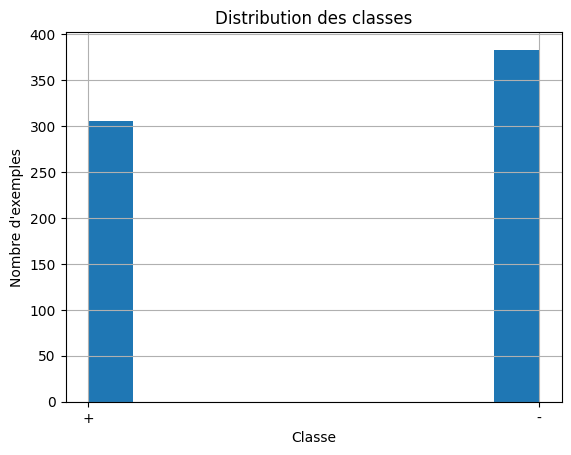

In [24]:
# Importation du jeu de données
df_client2=pd.read_csv('client.data',sep='\t',header=None)

# Transformation en numpy
client2=df_client2.to_numpy()

# Séparer les variables caractéristiques de la variable à prédire en deux tableaux différents
y=client2[:,-1] 
x=client2[:,0:-1]

# Sous-ensemble des donnnées
df_client2 = df_client2.replace("?", np.nan)
numeric = df_client2.apply(pd.to_numeric, errors='coerce')
x_numeric = numeric.dropna(axis=1, how='all')
x_numeric = x_numeric.astype(float)
indice_na = x_numeric.index[x_numeric.isna().any(axis=1)]

# Supprimer les nan
x_numeric=x_numeric.dropna()

# Propriétés des données
print('Taille de l\'échantillon : ',x_numeric.shape)

df_client2.iloc[:,-1].hist()
plt.xlabel('Classe')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des classes')
plt.show()

# Binariser y 
y_bin = np.where(y == "+", 1, 0)

In [30]:
from utils import run_classifiers_cv
clfs = {
    "CART": DecisionTreeClassifier(max_depth=3, random_state=1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(20,10), random_state=1, max_iter=500),
    "Bagging": sklearn.ensemble.BaggingClassifier(n_estimators=200, random_state=1, n_jobs=-1),
    "AdaBoost": sklearn.ensemble.AdaBoostClassifier(n_estimators=200, random_state=1),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1)
}
y_clean = np.delete(y_bin,indice_na,axis=0)
run_classifiers_cv(clfs,x_numeric,y_clean)


--- CART ---
Accuracy: 0.766 +/- 0.052
AUC: 0.801 +/- 0.043
(Accuracy+Précision)/2: 0.798 +/- 0.051
Temps d'exécution: 54.50 secondes

--- KNN ---
Accuracy: 0.709 +/- 0.039
AUC: 0.733 +/- 0.047
(Accuracy+Précision)/2: 0.710 +/- 0.043
Temps d'exécution: 0.15 secondes

--- MLP ---
Accuracy: 0.694 +/- 0.055
AUC: 0.724 +/- 0.064
(Accuracy+Précision)/2: 0.698 +/- 0.057
Temps d'exécution: 1.36 secondes

--- Bagging ---
Accuracy: 0.790 +/- 0.045
AUC: 0.837 +/- 0.052
(Accuracy+Précision)/2: 0.794 +/- 0.041
Temps d'exécution: 7.74 secondes

--- AdaBoost ---
Accuracy: 0.791 +/- 0.062
AUC: 0.853 +/- 0.044
(Accuracy+Précision)/2: 0.796 +/- 0.056
Temps d'exécution: 4.67 secondes

--- RandomForest ---
Accuracy: 0.787 +/- 0.054
AUC: 0.850 +/- 0.046
(Accuracy+Précision)/2: 0.792 +/- 0.048
Temps d'exécution: 5.13 secondes


{'CART': {'accuracy': np.float64(0.7657620985979194),
  'auc': np.float64(0.8013227165916454),
  'acc_prec': np.float64(0.7975292180003322)},
 'KNN': {'accuracy': np.float64(0.7086160108548168),
  'auc': np.float64(0.733245683495835),
  'acc_prec': np.float64(0.7104894086784677)},
 'MLP': {'accuracy': np.float64(0.6936227951153324),
  'auc': np.float64(0.7236137954477121),
  'acc_prec': np.float64(0.6975473325891031)},
 'Bagging': {'accuracy': np.float64(0.7898914518317504),
  'auc': np.float64(0.8370211311792357),
  'acc_prec': np.float64(0.7943534001416608)},
 'AdaBoost': {'accuracy': np.float64(0.7913839891451832),
  'auc': np.float64(0.8527397025002857),
  'acc_prec': np.float64(0.795653367383719)},
 'RandomForest': {'accuracy': np.float64(0.7868611488014473),
  'auc': np.float64(0.8496149643661959),
  'acc_prec': np.float64(0.7919274611069433)}}

Ici, lorsque que l'on compare les résultats, on voit que les méthodes d'ensemble telles que le Bagging, Adaboost et Random Forest sont les plus performantes et robustes pour ce jeu de données non normalisé. Tandis que les modèles qui sont sensibles au changement d'échelle comme le MLP ou le KNN sont moins robustes sans normalisation. On va le vérifier dans la question suivante.

-  Normalisation des variables continues

Dans cette section, on va normaliser les données et voir s'il y a une amélioration ou un changement dans les résultats.

In [46]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_numeric)
run_classifiers_cv(clfs,x_scaled,y_clean)


--- CART ---
Accuracy: 0.766 +/- 0.052
AUC: 0.801 +/- 0.043
(Accuracy+Précision)/2: 0.798 +/- 0.051
Temps d'exécution: 4.68 secondes

--- KNN ---
Accuracy: 0.745 +/- 0.062
AUC: 0.808 +/- 0.049
(Accuracy+Précision)/2: 0.767 +/- 0.071
Temps d'exécution: 0.09 secondes

--- MLP ---
Accuracy: 0.770 +/- 0.045
AUC: 0.836 +/- 0.036
(Accuracy+Précision)/2: 0.776 +/- 0.045
Temps d'exécution: 5.46 secondes

--- Bagging ---
Accuracy: 0.791 +/- 0.046
AUC: 0.837 +/- 0.052
(Accuracy+Précision)/2: 0.797 +/- 0.042
Temps d'exécution: 6.85 secondes

--- AdaBoost ---
Accuracy: 0.791 +/- 0.062
AUC: 0.853 +/- 0.044
(Accuracy+Précision)/2: 0.796 +/- 0.056
Temps d'exécution: 4.32 secondes

--- RandomForest ---
Accuracy: 0.788 +/- 0.051
AUC: 0.850 +/- 0.046
(Accuracy+Précision)/2: 0.793 +/- 0.048
Temps d'exécution: 5.26 secondes


{'CART': {'accuracy': np.float64(0.7657620985979194),
  'auc': np.float64(0.8013227165916454),
  'acc_prec': np.float64(0.7975292180003322)},
 'KNN': {'accuracy': np.float64(0.7449344188150159),
  'auc': np.float64(0.8075416335173164),
  'acc_prec': np.float64(0.7673819890722876)},
 'MLP': {'accuracy': np.float64(0.7703753957485301),
  'auc': np.float64(0.8361774833606314),
  'acc_prec': np.float64(0.7762122997092116)},
 'Bagging': {'accuracy': np.float64(0.7914066033469018),
  'auc': np.float64(0.8368341955664599),
  'acc_prec': np.float64(0.7966779274661882)},
 'AdaBoost': {'accuracy': np.float64(0.7913839891451832),
  'auc': np.float64(0.8527397025002857),
  'acc_prec': np.float64(0.795653367383719)},
 'RandomForest': {'accuracy': np.float64(0.7883536861148801),
  'auc': np.float64(0.8495955404267074),
  'acc_prec': np.float64(0.793058345148275)}}

La normalisation montre qu'il y a un impact majeur sur les données sensibles à l'échelle donc le KNN et le MLP. En effet les performances de ces derniers sont meilleures. 
Les méthodes d'ensemble restent les plus robustes et performantes, indépendamment du prétraitement. Parfois la normalisation permet d'optimiser les calculs et donc de réduire le temps d'exécution.
Cette comparaison permet de montrer l'importance d'adapter le prétraitement des données au type d'algorithme utilisé.

2. - Traitement des données manquantes

In [ ]:
X_df = df_client2.iloc[:,:-1]
X_df = X_df.replace("?", np.nan)
for c in X_df.columns:
    X_df[c] = pd.to_numeric(X_df[c], errors='ignore')
col_num = X_df.select_dtypes(include=[np.number]).columns
col_cat = X_df.select_dtypes(exclude=[np.number]).columns
print('numéros des colonnes numériques :' ,col_num)
print('numéros des colonnes catégorielles : ', col_cat)

numéros des colonnes numériques : Index([1, 2, 7, 10, 13, 14], dtype='int64')
numéros des colonnes catégorielles :  Index([0, 3, 4, 5, 6, 8, 9, 11, 12], dtype='int64')


In [44]:
# Traitement des données numériques
X = X_df.to_numpy()
X_num = np.copy(X[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)
X_num = scaler.fit_transform(X_num)

- Traitement de variables catégorielles

In [ ]:
X_cat = np.copy(X[:, col_cat])
imp_cat = SimpleImputer(strategy='most_frequent')
X_cat = imp_cat.fit_transform(X_cat)
for col_id in range(X_cat.shape[1]):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
    X_cat[:, col_id] = val_idx
X_cat = X_cat.astype(int)

onehot = OneHotEncoder()  
X_cat_bin = onehot.fit_transform(X_cat).toarray() 


- Construction du jeu de données

In [48]:
# COncaténation des données catégorielles transformées et des données continues normalisées
X_final = np.concatenate([X_cat_bin, X_num], axis=1)

results = run_classifiers_cv(clfs,X_final,y_bin)


--- CART ---
Accuracy: 0.830 +/- 0.031
AUC: 0.919 +/- 0.023
(Accuracy+Précision)/2: 0.836 +/- 0.042
Temps d'exécution: 4.01 secondes

--- KNN ---
Accuracy: 0.840 +/- 0.052
AUC: 0.900 +/- 0.037
(Accuracy+Précision)/2: 0.841 +/- 0.044
Temps d'exécution: 0.21 secondes

--- MLP ---
Accuracy: 0.842 +/- 0.053
AUC: 0.908 +/- 0.048
(Accuracy+Précision)/2: 0.832 +/- 0.054
Temps d'exécution: 4.32 secondes

--- Bagging ---
Accuracy: 0.878 +/- 0.035
AUC: 0.928 +/- 0.027
(Accuracy+Précision)/2: 0.868 +/- 0.035
Temps d'exécution: 4.52 secondes

--- AdaBoost ---
Accuracy: 0.856 +/- 0.038
AUC: 0.928 +/- 0.024
(Accuracy+Précision)/2: 0.843 +/- 0.050
Temps d'exécution: 2.32 secondes

--- RandomForest ---
Accuracy: 0.878 +/- 0.038
AUC: 0.931 +/- 0.029
(Accuracy+Précision)/2: 0.867 +/- 0.041
Temps d'exécution: 2.84 secondes


On voit qu'après avoir enlevé les valeurs manquantes, l'encodage des variables catégorielles et la normalisation des variables continues qu'il y a une importante amélioration globale des performances.\
Les méthodes d'ensemble restent les plus performantes et robustes, dont les meilleurs sont le Bagging et Random Forest avec environ 0.86 en moyenne entre l'accuracy et la précision. \
Mais les modèles sensibles à l'échelle et au prétraitement des données deviennent aussi très bons.